# Hit classification

In this notebook we will try to use Keras and XGBoost in order to distinguish between _true_ conversion electron hits and _fake_ conversion electron hits.

In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2022-12-23 15:18:19.104482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First of all we use [uproot](https://uproot.readthedocs.io/en/latest/), a library to reading ROOT files in pure Python and NumPy, to open the `trkana` tree in the `TAKK` folder of the `KKSM01.root` file. We only need certain branches, so we apply a filter to read only `de`, `detsh`, `detshmc`, and `demc`. We then apply a mask to our tree to select only good fits. 

In [2]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
filelist = os.environ['KKTrainData']
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        trkana = file["TAKK"]["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
        trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]
    udt = ak.concatenate(trkana['detsh.udt']).to_numpy()
    udoca = ak.concatenate(trkana['detsh.udoca']).to_numpy()
    rdrift = ak.concatenate(trkana['detsh.rdrift']).to_numpy()
    tottdrift = ak.concatenate(trkana['detsh.tottdrift']).to_numpy()
#    edep = ak.concatenate(trkana['detsh.edep']).to_numpy()
    udocavar = ak.concatenate(trkana['detsh.udocavar']).to_numpy()
    hstate = ak.concatenate(trkana['detsh.state']).to_numpy()
    print("Processed file " + filename + " with %s hits"%udt.shape[0])
    temp = np.vstack((udt,udoca,tottdrift,rdrift,udocavar)).T
    if input_dataset is np.empty:
        input_dataset = temp
    else:
        input_dataset = np.concatenate((input_dataset, temp))
    mcrel = []
    mcambig = []
    mcdist = []
    for i, this_dt in enumerate(trkana['detsh.udt']):
        mcrel.extend(trkana['detshmc.rel._rel'][i][:len(this_dt)])
        mcambig.extend(trkana['detshmc.ambig'][i][:len(this_dt)])
        mcdist.extend(trkana['detshmc.dist'][i][:len(this_dt)])
    mcrel = np.array(mcrel)
    mcambig = np.array(mcambig)
    mcdist = np.array(mcdist)

    sig = (hstate>-2) & (mcrel==0) & (mcambig*udoca>0) & (rdrift-mcdist<0.4)
    bkg = (hstate>-2) & (mcrel==0) & ((mcambig*udoca<0) | (rdrift-mcdist>0.4))
    if signal is np.empty:
        signal = sig
        backgnd = bkg
    else:
        signal = np.concatenate((signal,sig))
        backgnd = np.concatenate((backgnd,bkg))    
nhits=len(input_dataset)
print("Total dataset %s hits"%nhits)

Using files in /Users/brownd/data/42082053/files.txt
Processing: /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000005.root

Processed file /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000005.root
 with 580548 hits
Processing: /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000008.root

Processed file /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000008.root
 with 571683 hits
Processing: /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000024.root

Processed file /Users/brownd/data/42082053/nts.brownd.KKSeed.KKSNB.001210_00000024.root
 with 575947 hits
Total dataset 1728178 hits


Here we then assign a label to each hit as _signal_ or _background_, depending on the Monte Carlo truth information. Since the dimension of  `detshmc.rel._rel` is not guaranteed to be the same as the dimension of `detsh` we need to loop over all the entries.

In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for _unbalanced_ datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.

In [3]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

Training on 240192 matched hits


## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model which consists of 3 fully-connected (or _dense_) layers, each one followed by a _dropout_ layer, which helps to avoid overfitting. The model is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained for 50 epochs or until the validation loss doesn't improve for 5 epochs (`early_stop`). 

In [4]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model_ce=Model(inputs=input,outputs=output)
model_ce.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop]
                         )

Epoch 1/200


2022-12-23 15:19:50.808688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7506/7506 [==============================] - 9s 1ms/step - loss: 0.5971 - accuracy: 0.6861 - val_loss: 0.5897 - val_accuracy: 0.6903
Epoch 2/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.5886 - accuracy: 0.6913 - val_loss: 0.5876 - val_accuracy: 0.6903
Epoch 3/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.5843 - accuracy: 0.6953 - val_loss: 0.5717 - val_accuracy: 0.7096
Epoch 4/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.5232 - accuracy: 0.7515 - val_loss: 0.5009 - val_accuracy: 0.7665
Epoch 5/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.4964 - accuracy: 0.7703 - val_loss: 0.4940 - val_accuracy: 0.7708
Epoch 6/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.4939 - accuracy: 0.7718 - val_loss: 0.4984 - val_accuracy: 0.7697
Epoch 7/200
7506/7506 [==============================] - 8s 1ms/step - loss: 0.4923 - accuracy: 0.7731 - val_loss: 0.4958 - val_accuracy: 0.77

## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish between signal (true CE hits) and background (fake CE hits). We use the defualt hyperparameters.

In [5]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

[15:29:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/brownd/mambaforge/envs/KKTrain/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [6]:
prediction_ce = model_ce.predict(x_ce_test).ravel()
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

3753/3753 [==============================] - 2s 535us/step


In [7]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

The plot of the ROC curves clearly shows that the BDT outperforms the MLP. In principle, however, it should be possible to improve the MLP performances by optimizing the hyperparameters (learning rate, hidden layers, activation functions, etc.).

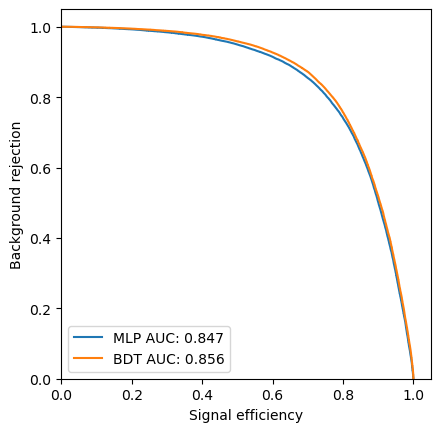

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.3f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.3f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0,1.05)
ax.set_ylim(0,1.05)
fig.savefig("TrainDrift.pdf")

In [11]:
output_model.set_weights(model_ce.get_weights())
output_model.summary()
output_model.save("TrainDrift.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 5)]                  0         
                                                                 
 dense (Dense)               (1, 10)                   60        
                                                                 
 dense_1 (Dense)             (1, 10)                   110       
                                                                 
 dense_2 (Dense)             (1, 10)                   110       
                                                                 
 dense_3 (Dense)             (1, 1)                    11        
                                                                 
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________
